In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

타이타닉에 탑승한 사람들의 신상정보를 활용하여 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것이다.

타이타닉 튜토리얼에서는 여러 시각화 도구(matplotlib, seaborn, plotly), 데이터 분석 도구(pandas, numpy), 머신러닝 도구(sklearn)을 사용할 것이다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. 
#matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
#일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

앞으로 우리가 해야할 프로세스는 대략 이러하다.

1. 데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제되어 있다. 하지만 가끔 null data가 존재하는데, 이를 확인하고, 향후 수정할 것이다.
2. 탐색적 데이터 분석(exploratory data analysis) -여러 feature들을 개별적으로 분석하고, feature들 간의 상관관계를 확인한다. 여러 시각화 툴을 사용하여 insight를 얻는다.
3. feature engineering- 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 한다. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 한다.
4. model만들기 - sklearn을 사용해 모델을 만든다. 파이썬에서 머신 러닝을 할 때는 sklearn을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있다. 물론 딥러닝을 위해 텐서플로우, 파이토치 등을 사용할 수도 있다.
5. 모델 학습 및 예측 - trainset을 가지고 모델을 학습시킨 후, testset을 가지고 predictio한다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단한다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다. 학습된 모델이 어떤 것을 학습하였는지 확인해본다.

# 1. Dataset 확인

* 파이썬에서 테이블화 된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 판다스이다.
* 우리는 판다스를 사용하여 데이터셋의 간단한 통계적 분석붙, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있다.
* 파이썬으로 데이터분석을 한다고 하면 반드시 능숙해져야 할 라이브러리이니, 여러 커널들을 공부하면서 사용법에 익숙해지도록 반복하는 것을 권장한다.
* 캐글에서 데이터셋은 보통 train, testset으로 나뉘어 있다.


In [3]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
df_train.head()

우리가 다루는 문제에서 feature는 Pcalss, Age, sibsp, Parch, Fare이고, 예측하려는 target label은 Survived이다.
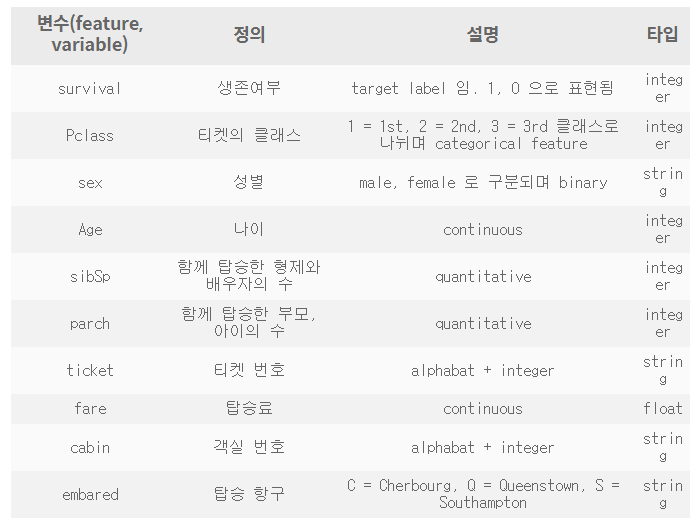

판다스 dataframe에는 describe()메소드가 있는데, 이걸 쓰면 각 feature가 가진 통계치들을 반환해준다.

In [5]:
df_train.describe()

In [6]:
df_test.describe()

테이블에서 보다시피, PassengerId 숫자와 다른, 그러니까 null data가 존재하는 feature가 있는 것 같다.(train- Age/ test- Age, Fare 컬럼의 count 수가 PassengerId count 수보다 적다)
이를 좀 더 보기 편하도록 그래프로 시각화해서 살펴보도록 하겠다.

# 1.1 Null data check

In [7]:
#df_test의 컬럼마다 몇 %의 결측치가 있는지 확인할 수 있는 코드
#test dataframe의 컬럼 하나씩 뽑는다
#{:>10}: 오른쪽 정렬
#:.2f}: 소수점 둘째자리까지 출력
for col in df_test.columns:
    #(하나씩 뽑은 컬럼의 null값이 몇개인지 합친 것 / df_test 컬럼의 값 개수 )를 {:.2f}자리에 넣기
    msg = 'column: {:>10}\t precent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

train, test set에서 둘다 Age는 약 20%, Cabin에서는 약 80%, 그리고 train의 Embarked는 0.22%의 null data가 존재한다는 것을 알 수 있다.

MANO 라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있다.


* iloc vs loc 차이

✔ loc

1. 데이터프레임의 행이나 컬럼에 label이나 boolean array로 접근

2. location의 약어로, 인간이 읽을 수 있는 label 값으로 데이터에 접근

 

✔ iloc

1. 데이터프레임의 행이나 컬럼에 인덱스 값으로 접근

2. integer location의 약어로, 컴퓨터가 읽을 수 있는 indexing 값으로 데이터에 접근

In [8]:
# df_train의 모든 행렬 값에 대한 결측치를 매트릭스로 시각화 해주기
msno.matrix(df = df_train.iloc[:, :], figsize = (8, 8), color= (0.8, 0.5, 0.2))

In [9]:
# df_train의 모든 행렬 값에 대한 결측치를 bar chart로 시각화 해주기
msno.bar(df=df_train.iloc[:, :], figsize = (8, 8), color = (0.8, 0.5, 0.2))

In [10]:
# df_test의 모든 행렬 값에 대한 결측치를 bar chart로 시각화 해주기
msno.bar(df=df_test.iloc[:, :],figsize = (8, 8), color=(0.8, 0.5, 0.2))

# 1.2 Target label확인
* target label이 어떤 distribution을 가지고 있는지 확인해봐야 한다
* 지금같은 binary classification문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있다.

In [11]:
#subplots()에선 두개의 값을 받을 수 있는데 figure 와 axes 값을 받을 수 있다.
#f(fig)=전체 사이즈
#ax(axe) = 전체 중 낱개
f, ax = plt.subplots(1, 2, figsize = (18, 8))

#value_counts(): 컬럼이나 시리즈의 유니크 밸류들의 수를 세어주는 함수
# 여기서는 survived 컬럼의 0, 1값들의 개수를 세어줌. 0, 1 말고 2도 있었다면 2의 개수도 세어서 pie plot으로 나타내졌을 것.
#Pie: 원 그래프
#explode: 부채꼴이 파이 차트의 중심에서 벗어나는 정도 [0, 1]에서, 0은 가만히 있고, 1만 중심에서 10% 벗어나서 나오게 한다.
#autopct: 부채꼴 안에 표시될 숫자의 형식
#shadow를 True로 설정하면, 파이 차트에 그림자가 표시된다.
#1.1f: 소수점 첫째 자리로 반올림
#ax=ax[0] : 그래프에 나타낼 때 0번째 인덱스 위치에 나타나게 하기
df_train['Survived'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax=ax[0], shadow = True)

#set_title: plot 이름 정하기
ax[0].set_title('Pie plot - Survived')
#set_ylabel : plot의 y축 이름
ax[0].set_ylabel('')

#df_train의 Survived 컬럼 데이터를 countplot으로 시각화하여 인덱스 [1]자리에 넣기
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

Survived = 1 : 생존

38.4%가 살아남았다.

# 2. Exploratory data analysis

* 이제 본격적으로 데이터 분석을 해보자. 데이터는 너무 많다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요하다.
* 시각화 라이브러리는 맷플롯립, seaborn, plotly 등이 있다. 특정 목적에 맞는 소스코드를 정리해두고 필요할 때마다 참고하면 편하다.

## 2.1. Pclass
* 먼저 Pclass에 대해서 살펴 보자. Pclass는 ordinal, 서수형 데이터이다. 카테고리이면서, 순서가 있는 데이터 타입이다.
* 먼저 Pclass에 따른 생존률의 차이를 살펴보자. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe에선 groupby를 사용하면 쉽게 할 수 있다. 또한 pivot이라는 메서드도 있다.
* 'Pclass', 'Survived',를 가져온 후, pclass로 묶는다. 그러고 나면 각 pclass마다 0, 1이 count가 되는데, 이를 평균내면 pclass별 생존률이 나온다.
* 아래와 같이 count()를 하면, 각 클래스에 몇 명이 있는지 확인할 수 있고, sum()을 하면, 216 명 중 생존한(survived=1)사람의 총합을 주게 된다.

In [12]:
#as_index = True : True말고 False로 지정하면 Pclass로 묶어지지 않는다.(밑의 표 처럼 Pclass가 인덱스화 되지 않는다.)
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = True).count()

In [13]:
#왜 생존자만 카운트 되는 거지? 라고 생각한다면 sum()은 그냥 숫자를 더해주는 것이기 때문에,
#생존=1이고 사망=0이라 숫자를 다 더하면 생존한 수가 되는 것이다.
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

* pandas의 crosstab을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있다.

In [14]:
#crosstab(index자리, 컬럼자리)
#margins = True : 총 합을 보고 싶을 때 사용
#cmap = 'summer_r' : 색 지정
# .style.background_gradient:그라데이션 스타일로 배경 색상을 지정
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins = True).style.background_gradient(cmap = 'summer_r')

* grouped 객체에 mean()을 하게 되면, 각 클래스별 생존률을 얻을 수 있다. class 1이면 80/(80+136)≈0.63 와 같다

In [15]:
#Survived 컬럼의 값을(by='Survived')
#내림차순으로(ascending=False)
#정렬 할 건데(.sort_values)
#bar chart 모양의 plot으로(.plot.bar()) 나타낼 것이다.
#.mean() 평균내면 생존률 얻을 수 있다
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = True).mean().sort_values(by='Survived', ascending=False).plot.bar()

* 보다시피, Pclass가 좋을 수록(1st) 생존률이 높은 것을 확인할 수 있다.
* 좀 더 보기 쉽게 그래프를 그려보자! seaborn의 countplot을 이용하면, 특정 label에 따른 개수를 확인해볼 수 있다.

In [16]:
#타이틀이 그래프 위에 얼마나 떨어져 있을지 정하기
y_position = 1.02

#그래프 전체 크기설정
f, ax = plt.subplots(1, 2, figsize = (12, 7))

#첫 번째 자리에 올 plot
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax = ax[0])
ax[0].set_title('Number of Passengers By Pclass', y= y_position)
ax[0].set_ylabel('Count')

#두 번째 자리에 올 plot
#카테고리형 데이터가 섞여 있는 경우에는 hue 인수에 카테고리 변수 이름을 지정하여 카테고리 값에 따라 색상을 다르게 할 수 있다.
sns.countplot('Pclass', hue='Survived', data = df_train, ax=ax[1])
ax[1].set_title('Pclass : Survived vs Dead', y = y_position)
plt.show()

In [17]:
#생존률 자세하게 안 나와서 추가함
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = True).mean()

* 클래스가 높을 수록, 생존 확률이 높은 걸 확인할 수 있습니다. Pclass 1, 2, 3 순서대로 63%, 48%, 25% 입니다.
* 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feature를 사용하는 걸이 좋은 것이라 판단할 수 있습니다.

# 2.2 Sex
* 이번에는 성별로 생존률이 어떻게 달라지는지 확인해보자.
* 마찬가지로 pandas groupby와 seaborn countplot을 사용해서 시각화해보자.

In [18]:
f, ax = plt.subplots(1, 2, figsize=(12, 7))

df_train[['Sex', 'Survived']].groupby(['Sex'], as_index = True).mean().plot.bar(ax = ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex', hue = 'Survived', data=df_train, ax = ax[1])
ax[1].set_title('Sex: Survived vs Dead')

plt.show()

보다시피, 여자가 생존할 확률이 높다.

In [19]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by = 'Survived', ascending=False)

In [20]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap = 'summer_r')

Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있다.

# 2.3. Both Sex and Pclass
* 이번에는 Sex, Pclass 두 가지에 관하여 생존이 어떻게 달라지는지 확인해보자
* seaborn의 factorplot을 이용하면, 손수비게 세 개의 차원으로 이루어진 그래프를 그릴 수 있다.

In [21]:
#클래스별 생존률을 알아보고, 그 생존률을 성별로 나눠서 보기
#factorplot(x,y,hue)
#hue로 지정된 필드의 종류만큼 라인이 그려진다.
#Aspect: 높이를 일정하게 유지하면서 너비를 변경
sns.factorplot('Pclass', 'Survived', hue = 'Sex', data=df_train, size=6, aspect=1.5)

* 모든 클래스에서 female이 male보다 살 확률이 높은 걸 알 수 있다.
* 또한 남자, 여자 상관없이 클래스가 높을 수록 살 확률이 높다.
* 위 그래프는 hue 대신 column으로 하면 아래와 같아진다.

* 각 포인트마다 세로 줄이 표시되어있는데 이는 에러바라고 하며, 그래프에서 불확실성 또는 오차 범위라고 이해하시면 될 것 같다.

In [22]:
#col의 경우, 지정해준 category별로 그래프를 새로 생성
#saturation : 채도설정
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, saturation =100, size=9, aspect=1)

# 2.4 Age
* 이번에는 age feature를 살펴보자

In [23]:
print('제일 나이 많은 탑승객: {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객: {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이: {:.1f} Years'.format(df_train['Age'].mean()))

* 생존에 따른 histogram 그려보기

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

#커널 밀도 추정 plot : 최대값, 최소값은 어떤지, 어떤 모양으로 얼마나 퍼져 있는지 분포 알 수 있음
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax = ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax = ax)

#범례 (Legend): 그래프에 데이터의 종류를 표시하기 위한 텍스트
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

In [25]:
# Age distribution withing classes
plt.figure(figsize = (8, 6))

#kernel density를 그리기 위해서 kind="kde" 파라미터를 추가함
df_train['Age'][df_train['Pclass'] == 1].plot(kind = 'kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind = 'kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind = 'kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

* Class가 높을 수록 나이 많은 사람의 비중이 커짐

 : 보통 나이가 많을 수록 모아놓은 돈도 많을테고 그러면 더 좋은 객실을 사용할 여유가 있기 때문이 아닐까(데이터 분석이랑은 별 상관 없을 거 같은데 그냥 드는 생각...)
 
* 나이대가 변하면서 생존률이 어떻게 되는지 보자.
* 나이 범위를 점점 넓혀가면서 생존률이 어떻게 되는지 한 번 보자.

In [26]:
#생존율을 리스트로 저장하자
cummulate_survival_ratio = []
for i in range(1, 80):
    #1부터 80까지 차례로 넣어주는데 i마다의 생존률을 리스트로 저장하도록 하나씩 추가한다
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))
    
plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

* 나이가 어릴 수록 생존률이 확실히 높다.
* 이러한 경향으로 보아, 중요한 feature로 사용할 수 있음을 확인했다.

# 2.5. Pclass, Sex, Age
* 지금까지 본, Sex, Pclass, Age, Survived 모두에 대해서 보고 싶을 땐, 이것들을 쉽게 그려주는 seaborn의 violinplot을 사용하면 된다.
* x축은 우리가 나눠서 보고싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(여기선 Age)을 나타낸다.

그려보자!

In [27]:
f, ax = plt.subplots(1, 2, figsize = (18, 8))

#scale:바이올린의 너비를 조정하는 데 사용
#scale = 'count': 바이올린 너비가 해당 빈(여기서는 컬럼)에 있는 관측치 수로 조정됨
#split을 True로 설정하면 각 레벨에 대해 바이올린 반으로 나뉨
sns.violinplot("Pclass", "Age", hue = 'Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pcalss and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", 'Age', hue= "Survived", data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()


* 왼쪽 그림은 Pclass 별로 age의 distribution이 어떻게 다른지를 생존 여부에 따라 구분한 그래프이다.
* 오른쪽 그림은 Sex별로 age의 disrtibution 이 어떻게 다른지를 생존 여부에 따라 보여주는 그래프이다.
* 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한 것을 볼 수 있다.
* 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한 것을 볼 수 있다.
* 여성과 아이를 먼저 챙긴 것이다.

# 2.6. Embarked
* Embarked는 탑승한 항구를 나타낸다.
* 위에서 했던 것과 비슷하게 탑승한 곳에 따른 생존률을 살펴보자.

In [28]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

* 결과를 보면, 조금의 차이는 있지만 생존률 자체는 비슷하다고 볼 수 있다. 그래도 C 항구에서 탑승한 승객들의 생존률이 가장 높은 것을 알 수 있다.
* 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠다.
* 사실, 모델을 만들고 나면 우리가 사용한 feature 들이 얼마나 중요한 역할을 했는지 확인해볼 수 있다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것이다.


#### 다른 feature로 split하여 한 번 살펴보겠다.

In [29]:
f, ax = plt.subplots(2, 2, figsize = (20, 15))
sns.countplot('Embarked', data = df_train, ax = ax[0, 0])
ax[0, 0].set_title('(1) No. Of Passengers Boarded')

sns.countplot('Embarked', hue = 'Sex', data=df_train, ax=ax[0, 1])
ax[0, 1].set_title('(2) Male-Female Split for Embarked')

sns.countplot('Embarked', hue = 'Survived', data=df_train, ax = ax[1, 0])
ax[1, 0].set_title('(3), Embarked vs Survived')

sns.countplot('Embarked', hue = 'Pclass', data=df_train, ax=ax[1, 1])
ax[1, 1].set_title('(4) Embarked vs PClass')

#subplots_adjust: 현재 배치되어 있는 subplot들의 위치를 직접 조정
#wspace, hspace: 서브플롯 간의 간격을 위해 각각 figure의 너비와 높이에 대한 비율 조절
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 전체적으로 봤을 때, S에서 가장 많은 사람이 탑승했다.
* Figure(2) - C와 Q는 남녀의 비율이 비슷하고, S는 남자가 더 많다.
* Figure(3) - 생존확률이 S의 경우 많이 낮은 걸 볼 수 있다. (3)의 그래프 상으로는 S가 많이 생존한 것처럼 보이지만(사람 수 상으로는 맞지만) 전체 탑승한 사람들에 비해 생존자의 비율이 낮다는 것을 먼저 확인했던 그래프를 통해 알 수 있다.
* Figure(4) - Class로 split해서 살펴보니, C가 생존확률이 높은건 전체 탑승자 대비 높은 클래스(1클래스)의 탑승자 비율이 많이 때문이고, S가 생존확률이 제일 낮았던 것은 클래스3 이용객들의 수가 많기 때문이다.

# 2.7. Family -SibSp(형제 자매) + Parch(부모, 자녀)
* SibSp와 Parch를 합하면 Family가 될 것이다. Family로 합쳐서 분석해보자.

In [30]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니까 1을 더한다.
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 #자신을 포함해야니까 1을 더함
#자신을 포함해야한다는 것은(1을 더해주는 이유는), 형제자매도 부모자식도 없는 1인 가구일 시(여기서는 혼자 타이타닉호를 탔을 경우)를 위해 더해주는 것 같다.

In [31]:
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

* FamilySize와 생존의 관계를 한 번 살펴보자 

In [32]:
f, ax = plt.subplots(1, 3, figsize = (40,10))

sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('[1] No. Of passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue = 'Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamiliySize', y = 1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure (1) - 가족크기가 1~11까지 있음을 볼 수 있다(위에서 그렇게 설정했으니까). 대부분 1명이고 그 다음으로 2, 3, 4명이다.
* Figure (2), (3) - 가족 크기에 따른 생존 비교이다. 가족이 4명인 경우가 가장 생존확률이 높다. 가족 수가 많아질 수록(5, 6, 7, 8, 11 순으로) 생존확률이 낮아진다.
* 가족 수가 너무 작아도(1), 너무 커도(5, 6, 8, 11) 생존 확률이 작다. 가족 구성원이 3~4명일 때 생존확률이 높은 걸 확인할 수 있다.

# 2.8. Fare
* Fare는 탑승요금이며, continous feature 이다. 한 번 히스토그램을 그려보자

In [33]:
fig, ax = plt.subplots(1, 1, figsize= (8, 8))

#skew : 표본 비대칭도이다. 자료의 치우친 정도를 소수점 둘째자리까지의 수치로 나타냄
g = sns.distplot(df_train['Fare'], color = 'b', label = 'Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)

#legend(loc = 'best'): best그래프 중 최적의 위치에 범례를 표시하겠다는 뜻
g = g.legend(loc = 'best')

* 보다시피, distrubution이 매우 비대칭인 것을 알 수 있다.(highskewness). 만약, 이대로 모델에 넣어주게 되면 자칫 모델이 잘못 학습할 수도 있다. 몇 개 없는 outlier에 대해 너무 민감하게 반응하면 실제 예측 시에 좋지 못한 결과를 부를 수 있다.
* outlier의 영향을 줄이기 위해 Fare에 log를 취할 것이다.
* 여기서 pandas의 유용한 기능을 사용할 것이다. dataFrame의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply를 사용하면 매우 손쉽게 적용할 수 있다.
* 우리가 지금 원하는 것은 Fare columns의 데이터 모두를 log값 취하는 것인데, 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns 데이터에 그대로 적용이 된다. 매우 유용한 기능이니 꼭 숙지하기!!


In [34]:
#아래 줄은 뒤늦게 발견했다. 13번째 강의에 언급되니, 일단 따라치고 넘어가면 된다.
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() #testset에 있는 nan value를 평균값으로 치환한다.

# 'Fare'값을 그냥 사용하면 값이 너무 몰려있어서 데이터로 사용하기 부적합하기에 log를 씌워서 정규화시켜 비대칭성 완화해주기
df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i> 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color = 'b', label = 'skewness : {:.2f}'.format(df_train['Fare'].skew()), ax = ax)
g = g.legend(loc='best')

* log를 취하니 이제 비대칭성이 많이 사라진 것을 볼 수 있다.

* 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있다.

* 방금 한 것은feature engineering에 들어가는 부분인데, 여기서 작업한 것이다.

* 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering이라고 하는데, 이제 그것을 살펴볼 것이다.

# 2.9. Cabin
* 이 feature는 NaN이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않을 것이다.
* 그러므로 우리가 세우려는 모델에는 쓰지 않겠다.

In [36]:
df_train.head()

# 2.10. Ticket
* 이 feature는 NaN은 없다.
* 일단 string data라서 어떤 작업들을 해 줘야 실제 모델에 사용할 수 있는데, 이를 위해선 아이디어가 필요하다.

In [37]:
df_train['Ticket'].value_counts()

* 보면 알 수 있듯이, ticket number는 매우 다양하다. 여기서 어떤 특징을 이끌어내서 생존과 연관시킬 수 있을까?

! 한 번 생각해보도록 하자 ! 라고 했지만, 아직 튜토리얼이니까 티켓은 넘기겠다고 한다.


**여기까지 타이타닉 데이터로 하는 튜토리얼 1은 끝이다!**

# 튜토리얼 2

: Exploratory data analysis, visualization, machine learning

In [38]:
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

# 3. Feature engineering
* 본격적인 feature engineering을 시작해볼 것이다.
* 가장 먼저, dataset에 존재하는 null data를 채우려고한다.
* 아무 숫자로 채울 수는 없고, null data를 포함하는 feature의 statisics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있다.
* null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분이다.
* Feature engineering은 실제 모델의 학습에 쓰려고 하는 것이므로, train뿐만 아니라 test도 똑같이 적용해주어야 한다.

# 3.1. Fill Null
# 3.1.1. Fill Null in Age using title
* Age에는 Null data가 177개나 있다. 이를 채울 수 있는 여러 아이디어가 있을 텐데, title + statistics를 사용할 것이다.
* 영어에서는 Miss, Mrr, Mrs와 같은 title이 존재한다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용해 보겠다.
* pandas series에는 data를 string으로 바꿔주는 str method, 거기에 정규 표현식을 적용하게 해주는 extract method가 있다. 이를 사용하여 title을 쉽게 추출할 수 있다. title을 initial columns에 저장하겠다.

In [39]:
#str: data를 string으로 바꿔준다
#extract: 정규표현식을 적용하게 해준다.
#([A-Za-z]+)\. : 대문자, 소문자 알파벳만으로 구성된 한 개 이상의 문자에다가 '.' 붙는 애들을 가져온다
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') #let's extract the Salutations

df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.') #let's extract the Salutations

pandas의 crosstab을 이용하여 우리가 추출한 Initial과 Sex 간의 count를 살펴보자

In [40]:
#T: 전치하기
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap = 'summer_r') #checking the Initials with the sex

* 위 table을 참고하여, 남자, 여자가 쓰는 initial을 구분해 보겠다.
* replace 메서드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해준다.

In [41]:
#1행의 데이터 값을 2행의 데이터 값으로 바꾸기
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [42]:
df_train.groupby('Initial').mean()

여성과 관계있는 Miss, Mrs가 생존률이 높은 것을 볼 수 있다.

In [43]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* 이제 본격적으로 Null을 채울 것이다. null data를 채우는 방법은 정말 많이 존재한다. statstics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있다. 여기서는 statistics를 활용하는 방법을 사용할 것이다.
* 여기서 statistics는 train data의 것을 의미한다. 우리는 언제나 test를 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 한다.

In [44]:
df_train.groupby('Initial').mean()

* Age의 평균을 이용해 Null value를 채우도록 하겠다.
* pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 참으로 편리하다.
* 아래 코드 첫줄을 해석하자면, isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age'의 값을 33으로 치환한다라는 뜻이다.
* loc + boolean + cloumn을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해지자.


* loc :  라벨값 기반의 2차원 인덱싱
* iloc : 순서를 나타내는 정수 기반의 2차원 인덱싱
* at : 라벨값 기반의 2차원 인덱싱 (한 개의 스칼라 값만 찾는다)
* iat : 순서를 나타내는 정수 기반의 2차원 인덱싱 (한 개의 스칼라 값만 찾는다)

In [45]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] =36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'), 'Age'] =22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'), 'Age'] =46

* 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재한다.
* https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보자!
* 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보자

# 3.1.2. Fill null in Embarked

In [46]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

* Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠다.
* dataFrame의 fillna method를 이용하면 쉽게 채울 수 있다. 여기서 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 된다(null인 곳을 S로 채우게 된다).

In [47]:
df_train['Embarked'].fillna('S', inplace=True)

# 3.2. Change Age(continuous to categorical)

* Age는 현재 continuous feature이다. 이대로 써도 모델을 세울 수 있지만, Age를 몇 개의 그룹으로 나누어 카테고리화 시켜줄 수도 있다.
* continuous를 categrical로 바꾸면 자칫 information loss가 생길 수도 있지만 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이라 그냥 진행하도록 하겠다.

* 방법은 여러가지가 있다. dataframe의 indexing방법인 loc를 사용하여 직접해줄 수 있고, 아니면 apply를 사용해 함수를 넣어줄 수도 있다.
* 첫 번째로 loc를 사용한 방법이다. loc는 자주쓰게 되므로 그 사용법을 숙지하는 것이 좋다.



In [48]:
#나이는 10살 간격으로 나누겠다.
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] <10, 'Age_cat'] = 0
df_train.loc[(10<= df_train['Age']) & (df_train['Age'] <20), 'Age_cat'] = 1
df_train.loc[(20<= df_train['Age']) & (df_train['Age'] <30), 'Age_cat'] = 2
df_train.loc[(30<= df_train['Age']) & (df_train['Age'] <40), 'Age_cat'] = 3
df_train.loc[(40<= df_train['Age']) & (df_train['Age'] <50), 'Age_cat'] = 4
df_train.loc[(50<= df_train['Age']) & (df_train['Age'] <60), 'Age_cat'] = 5
df_train.loc[(60<= df_train['Age']) & (df_train['Age'] <70), 'Age_cat'] = 6
df_train.loc[70<= df_train['Age'], 'Age_cat'] =7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] <10, 'Age_cat'] =0
df_test.loc[(10<= df_test['Age']) & (df_test['Age'] <20), 'Age_cat'] = 1
df_test.loc[(20<= df_test['Age']) & (df_test['Age'] <30), 'Age_cat'] = 2
df_test.loc[(30<= df_test['Age']) & (df_test['Age'] <40), 'Age_cat'] = 3
df_test.loc[(40<= df_test['Age']) & (df_test['Age'] <50), 'Age_cat'] = 4
df_test.loc[(50<= df_test['Age']) & (df_test['Age'] <60), 'Age_cat'] = 5
df_test.loc[(60<= df_test['Age']) & (df_test['Age'] <70), 'Age_cat'] = 6
df_test.loc[70<= df_test['Age'], 'Age_cat'] = 7
             

* 두 번째로 간단한 함수를 만들어 apply 메서드에 넣어주는 방법이다.
* 훨씬 수월하다.

In [49]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] =df_train['Age'].apply(category_age)

* 두 가지 방법이 잘 적용 되었다면, 둘 다 같은 결과를 내야한다.
* 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메서드를 사용하자.
* all() 메서드는 모든 값이 True면 True, 하나라도 False가 있으면 False를 준다.

In [50]:
#all() 메서드는 모든 값이 True면 True, 하나라도 False가 있으면 False를 준다.
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

* 결과가 True이다. 둘 중 편한 걸 선택하면 된다.
* 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거해주자

In [51]:
#drop : 컬럼 삭제
#drop에서 axis=1: 행이 아닌 '컬럼' 삭제 
#inplce = True : inplace 옵션이 True이면,  명령어를 실행 한 후 메소드가 적용된 데이터 프레임으로 반환 한다.
#즉, 삭제 메소드를 실행했다면 반환값은 컬럼이 삭제된 Dataframe이 된다. 
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis = 1, inplace=True)

# 3.3. Change initial, Embarked and Sex ( string to numerical)
* 현재 Initial은 Mr, Mrs, Miss, Master, Other 총 다섯 개로 이루어져 있다. 이런 카테고리로 표현되어 있는 데이터를 모델에 인풋으로 넣어줄 때 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시키는 것이다.
* map method를 가지고 간단히 할 수 있다.
* 사전 순서대로 정리하여 mapping 하겠다.

In [52]:
#map 함수는 리스트의 요소를 지정된 함수로 처리해준다.
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss' : 1, 'Mr' : 2, 'Mrs' : 3, 'Other' : 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs' : 3, 'Other' : 4})

* Embarked 도 C, Q, S로 이루어져 있다. map을 이용해 바꿔보자.
* 그러기 앞서서, 특정 columns에 어떤 값들이 있는지 확인해보는 방법을 잠깐 살펴보겠다. 간단히 unique()메서드를 쓰거나, value_counts()를 써서 count까지 보는 방법이 있다.

In [53]:
#특정 columns에 어떤 값들이 있는지 확인해보는 방법
# 1.unique()메서드
df_train['Embarked'].unique()

In [54]:
# 2.value_counts() 로 count까지 보는 방법(개수까지 세아리는 방법)
df_train['Embarked'].value_counts()

위 두가지 방법으로 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있다. 이제 map을 사용하여 값들을 수치화 시켜보자

In [55]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

* 한 번 눌이 사라졌는지 확인해보자. 가져온 Embarked cloumn은 하나의 pandas의 Series객체이기 때문에, isnull() 메서드를 사용해 Series의 값들이 Null인지 아닌지에 때한 boolean 값을 얻을 수 있다. 그리고 이것에 any()를 사용하여, True가 단 하나라도 있을 시(컬럼의 데이터에 Null이 한 개라도 있을 시) True를 반환해주게 된다. 

* 여기서 우리는 Null을 S로 다 바꿔주었기 때문에 False를 얻게 된다.

isnull() : True-null 값 존재, False - null 값 없음

In [56]:
#isnull()로 null 존재 유무 확인
df_train['Embarked'].isnull().any()

False값이 나왔다. 이로써, Embarked cloumn에는 null값이 없다.

이제 cloumn Female, male로 이루어져 있는 Sex cloumns을 map을 이용해 수치화 시키자

In [57]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

* 이제 각 feature간의 상관관계를 보려고 한다.
* 두 변수간의 Pearson correlation을 구하면 (-1, 1) 사이의 값을 얻을 수 있다. -1로 갈 수록 음의 상관관계, 1로 갈 수록 양의 상관 관계를 의미하며, 0은 상관관계가 없다는 것을 의미한다.

구하는 수식은

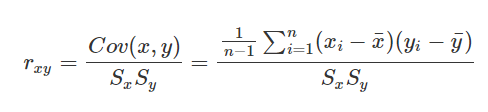

이러하다.

* 타이타닉 데이터에는 여러 feature값을 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편한데, 그렇게 볼 수 있는 것을 heatmap plot이라고 하며, dataframe의 corr() 메서드와 seaborn을 가지고 편하게 그릴 수 있다.

In [58]:
#heatmap plot 구하기
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

#plt.cm.RdBu = 컬러맵을 나타낸다.
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correalation of Features',y=1.05, size=15)

#astype: 데이터 프레임 타입 바꾸기
#corr() : 상관계수 계산
#linewidths: 상관계수 블록 사이의 경계선 굵기
#vmax: heatmap 오른쪽에 위치한 컬러바의 최댓값을 지정. 색으로 표현하는 값의 최댓값 정해줄 수 있음
#square :셀을 정사각형으로 출력할 것인가
#cmap :히트 맵 색상을 바꿀 수 있다. summer_r로 지정하면 위에서 봤던 초록 노랑 맵 나올듯
#linecolor :경계선 색깔
#annot: True여야 각 셀의 값을 표기할 수 있음
#annot_kws: 상관계수 글자 크기
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16})

del heatmap_data

* EDA에서 살펴봤듯이, Sex와 Pclass가 Survived에 상관관계가 어느 정도 있음을 볼 수 있다.
* 생각보다 fare와 Embarked도 상관관계가 있음을 볼 수 있다(음이든 양이든 0에서 좀 벗어난 값임).
* 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것이다.
* 이것은 모델을 학습시킬 때, 불필요한 (redundant, superfluous) feature가 없다는 뜻이다. 1 또는 -1의 상관관계를 명확히 가진 feature A, B가 존재한다면, 실질적으로 얻을 수 있는 정보는 하나일 것이기 때문이다.(명확한 상관관계를 가졌다면, 그런 상관관계에 있는 feature 때문에 그러한 결과가 나왔다는 것이라고 볼 수 있기 때문)

#### 이제 실제로 모델을 학습시키기 앞서서 data preprocessing(전처리)을 진행해 볼 것이다.

# 3.4. One-hot encoding on Initial and Embarked
* 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해 볼 수 있다.
* 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4로 mapping해주는 것을 말한다.
* One-hot encoding은 위 카테고리를 아래와 같이 (0, 1)로 이루어진 5차원의 벡터로 나타내는 것을 말한다.
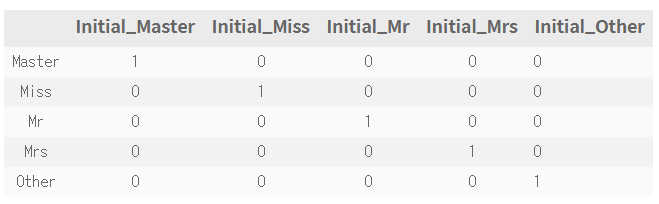
* 위와 같은 작업을 직접 코딩할 수도 있지만, pandas의 get_dummies를 사용하여 쉽게 해결할 수 있다.
* 총 5개의 카테고리이니, one-hot encoding을 하고 나면 새로운 5개의 columns이 생겨날 것이다.
* Initial을 prefix로 두어서 구분이 쉽게 만들어 주자

In [59]:
# get_dummies를 사용하여 initail에 존재하는 값들로 컬럼 나누기
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [60]:
df_train.head()

* dataframe 오른 쪽에 만드려고 했던 one-hot encoded columns가 생성된 것이 보인다.
* Embarked에도 적용해보자. Initial 때와 마찬가지로 one-hot encoding을 사용해 표현해보자.

In [61]:
#Embarked에 원핫 인코딩 사용
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

* 쉽게 원핫 인코딩을 적용했다.
* sklearn으로 labelencoder + OneHotencoder를 이용해도 원핫 인코딩이 가능하다.



### **+)** 다음에 다뤄 볼 것
* 여기서는 get_dummies로 충분히 가능해서 다른 튜토리얼에서 두 번째 줄의 내용을 사용해 볼 것이다.
* 가끔 categoryrk 100개가 넘어가는 경우가 있다. 이때 원핫 인코딩을 사용하면 column이 100개가 생겨서, 학습시 매우 버거울 경우가 생길 수 있다. 이런 경우에는 원핫 인코딩 말고 다른 방법을 사용하기도 하는데, 이 또한 다음에 다뤄 보도록 하겠다.

# 3.5. Drop columns
* 이제 불필요한 데이터를 지우도록 하자. 필요한 columns만 남기고 다 지워 보자.

In [62]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace=True)

In [63]:
#컬럼들 잘 지워졌는지 확인
df_train.head()

In [64]:
df_test.head()

* 지우기 위해 입력했던 컬럼들이 모두 지워졌고, train data의 훈련을 위한 target data(Survived)를 빼면, train과 test가 같은 columns를 가진 걸 확인 할 수 있다.

# 4. Building machine learning model and prediction using the trained model
* 이제 준비가 다 되었으니 sklearn을 사용해 본격적으로 머신러닝 모델을 만들어 보자

In [65]:
#importing all the requried ML packages
from sklearn.ensemble import RandomForestClassifier #유명한 randomforestclassifier이다.
from sklearn import metrics
from sklearn.model_selection import train_test_split #training set을 쉽게 나눠주는 함수이다.

* sklearn은 머신러닝의 처음부터 끝까지가 다 있다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있다. 데이터 분석 + 머신러닝을 하고 싶다면, 이 라이브러리른 ㄴ반드시 숙지해야한다.
* 파이썬 라이브러리를 활용한 머신러닝(Introduction to machine larning with Python) 책을 사서 공부하시길 매우 추천드립니다.

* 지금 타이타닉 문제는 target class(survived)가 있으며, target class는  0, 1로 이루어져 있으므로, binary classification 문제이다.
* 가지고 있는 train set의 sruveived를 제외한 input을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 낸다.
* 그 후 모델이 학습하지 않았던 test set을 input으로 줘서 test set의 각 샘플(탑승객)의 생존유무를 예측해 본다.

# 4.1. preparation - Split dataset into train, valid, test set
* 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리한다. (drop을 사용해 간단히 할 수 있다.)

In [66]:
#survived 삭제한 후 밸류값들은 X_train에, Survived 단독으로 분리한 뒤 밸류값들 target_label에 저장
X_train =df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

* 보통 train, test 데이터 세트만 언급되지만, 실제로는 좋은 모델을 만들기 위해서 valid set을 따로 만들어 test 세트로 모델 평가 하기 전에 따로 모델 평가를 해본다.
* 예를 들어 설명하자면, 마치 축구 대표팀이 팀 훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 평가전(vaild)을 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷하다.
* train_test_split을 이용하여 쉽게 train 셋을 분리할 수 있다.

In [67]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state = 2018)

* sklearn에서는 여러 머신러닝 알고리즘을 지원해준다. 
* 본 튜토리얼에서는 랜덤포레스트를 사용할 것이다.
* 랜덤 포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델이다.
* 각 머신러닝 알고리즘에는 여러 파라미터들이 있는데 랜덤포레스트 분류기는 n_estimators, max_features, max_depth, mis_samples_split, min_samples_leaf 등 여러 파라미터들이 존재한다. 이것들이 어떻게 세팅되느냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라진다.
* 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요하다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이다. 
* 튜토리얼이니 파라미터 튜닝은 제쳐두고, 기본 default 세팅으로 진행하도록 하겠다.
* 모델 객체를 만들고, fir 메서드로 학습시킨다.
* 그런 후, vaild set input을 넣어주어 예측값(X_vid sample(탑승객)의 생존여부)를 얻는다.

# 4.2 Model generation and prediction

In [68]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

* 단 세 줄만으로 모델을 세우고, 예측도 했다.
* 모델의 성능을 살펴 보자.

In [69]:
#밑 코드에서 y_vld.shape[0]을 쓰길래 처음 인덱스 값이 268이 맞는지 확인하기 위해 추가
y_vld.shape

In [70]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

* 아무런 파라미터 튜닝도 하지 않았는데 82%의 정확도가 나왔다.

# 4.3. Feature importance
* 학습된 모델은 feature importance를 가지게 되는데, 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있다.
* 학습된 모델은 기본적으로 feature importances를 가지고 있어서 쉽게 그 수치를 얻을 수 있다.
* pandas series를 이용하면 쉽게 sorting 하여 그래프를 그릴 수 있다.

In [71]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

In [72]:
plt.figure(figsize=(8, 8))

#barh(): 수평 막대 그래프
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

* 우리가 전처리한 데이터를 사용한 랜덤포레스트 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 initial_2, Age_cat, pclass가 차례로 중요도를 가진다.
* feature importance는 지금 모델에서의 importance를 나타낸다. 만약 다른 모델을 사용하게 된다면 feature importance가 다르게 나올 수 있다.
* 이 feature importance를 보고 실제로 Fare가 중요한 feature일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야한다.
* feature importance를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 좀 더 빠른 모델을 위해 feature제거를 할 수 있다.

# 4.4. Prediction on Test set
* 이제 모델이 학습하지 않았던(타이타닉 캐글 시작할 때 따로 주어졌던 나머지 한 개의 파일) 테스트 셋을 모델에 주어서, 생존여부를 예측해보겠다.
* 이 결과는 실제로 submission(제출용)이므로 결과는 leaderboard에서 확인할 수 있다.
* 캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 해보자

In [73]:
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [74]:
submission.head()

이제 test set에 대하여 예측을 하고, 결과를 csv파일로 저장해보겠다.

In [75]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [76]:
submission.to_csv('./my_first_submission.csv', index=False)

* 캐글에 제출해보자

0.75358의 score가 나왔다.